In [43]:
# Cell 1: Import Library
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns

# Cek device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Eksplorasi Autoencoder - Tugas Individu

Notebook ini mengeksplorasi model Autoencoder menggunakan CNN pada dataset Fashion MNIST. Fokus eksplorasi adalah melihat bagaimana struktur encoder-decoder memengaruhi hasil rekonstruksi dan representasi laten.


In [44]:
# Cell 2: Load Dataset (Fashion MNIST)
transform = transforms.ToTensor()

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                                   download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                                  download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

classes = train_dataset.classes


## Arsitektur Autoencoder

Model menggunakan 3 lapis encoder dan 3 lapis decoder berbasis CNN. Setiap lapisan encoder mengurangi dimensi, dan decoder berfungsi membalikkan proses tersebut untuk merekonstruksi citra.


In [45]:
# Cell 3: Definisi Model Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim=64):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 28x28 → 14x14
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # 14x14 → 7x7
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 7x7 → 4x4
            nn.ReLU()
        )
        # Bottleneck
        self.fc1 = nn.Linear(64 * 4 * 4, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 64 * 4 * 4)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # 4x4 → 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # 8x8 → 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),   # 16x16 → 32x32
            nn.ReLU(),
            nn.Conv2d(1, 1, kernel_size=5, stride=1, padding=2),  # 32x32 → 28x28
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        latent = self.fc1(x)
        return latent

    def decode(self, latent):
        x = self.fc2(latent)
        x = x.view(x.size(0), 64, 4, 4)
        x = self.decoder(x)
        return x

    def forward(self, x):
        latent = self.encoder(x)
        decoded = self.decoder(latent)
        
        # Pastikan output sama dengan input (28x28)
        decoded = decoded[:, :, :28, :28]
        
        return decoded, latent


In [46]:
# Cell 4: Inisialisasi Model
latent_dim = 32
model = ConvAutoencoder(latent_dim=latent_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


## Pelatihan Model

Model dilatih menggunakan fungsi loss MSE dan optimizer Adam selama X epoch. Dataset Fashion MNIST digunakan sebagai input karena strukturnya cocok untuk autoencoder berbasis citra.


In [47]:
# Cell 5: Training Loop
num_epochs = 20
train_loss_history = []

model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, _ in train_loader:
        images = images.to(device)

        optimizer.zero_grad()
        outputs, _ = model(images)

        # Tidak perlu crop di sini jika sudah dicrop di forward()
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_loss_history.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/20], Loss: 0.1481
Epoch [2/20], Loss: 0.1302
Epoch [3/20], Loss: 0.1256
Epoch [4/20], Loss: 0.1247
Epoch [5/20], Loss: 0.1246
Epoch [6/20], Loss: 0.1246
Epoch [7/20], Loss: 0.1246
Epoch [8/20], Loss: 0.1246
Epoch [9/20], Loss: 0.1246
Epoch [10/20], Loss: 0.1246
Epoch [11/20], Loss: 0.1246
Epoch [12/20], Loss: 0.1246
Epoch [13/20], Loss: 0.1246
Epoch [14/20], Loss: 0.1246
Epoch [15/20], Loss: 0.1246
Epoch [16/20], Loss: 0.1246
Epoch [17/20], Loss: 0.1246
Epoch [18/20], Loss: 0.1246
Epoch [19/20], Loss: 0.1246
Epoch [20/20], Loss: 0.1246


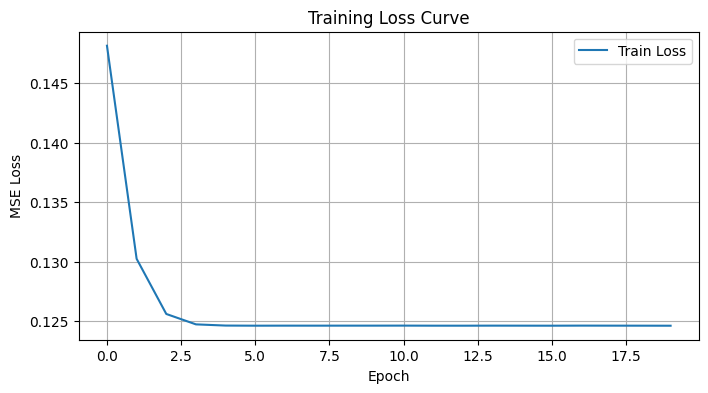

In [48]:
# Cell 6: Plot Loss Curve
plt.figure(figsize=(8, 4))
plt.plot(train_loss_history, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()


## Evaluasi Performa

Berikut adalah grafik penurunan loss selama pelatihan. Loss yang menurun stabil menunjukkan model belajar merekonstruksi dengan baik.


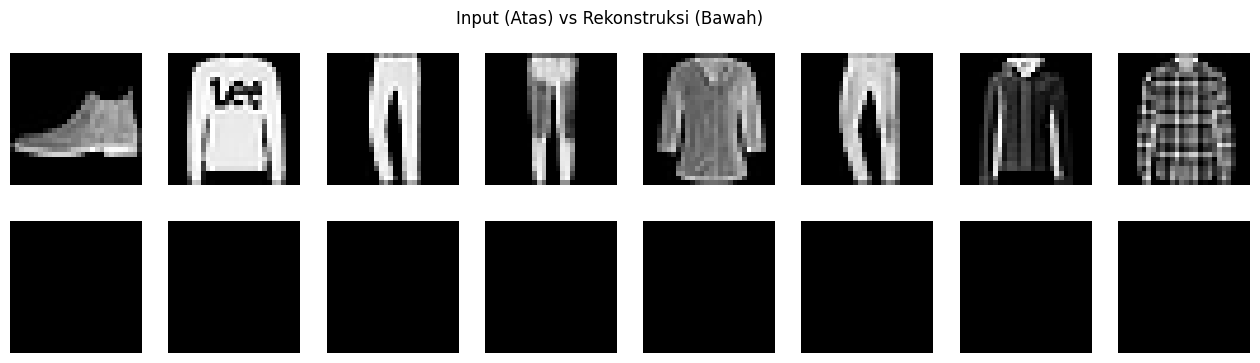

In [49]:
# Cell 7: Rekonstruksi Gambar
model.eval()
images, _ = next(iter(test_loader))
images = images.to(device)
with torch.no_grad():
    outputs, _ = model(images)

# Visualisasi input vs output
n = 8
plt.figure(figsize=(16, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(outputs[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
plt.suptitle("Input (Atas) vs Rekonstruksi (Bawah)")
plt.show()


## Visualisasi Rekonstruksi

Berikut adalah perbandingan gambar asli (atas) dan hasil rekonstruksi (bawah). Secara visual, model mampu menangkap bentuk umum dan struktur objek.


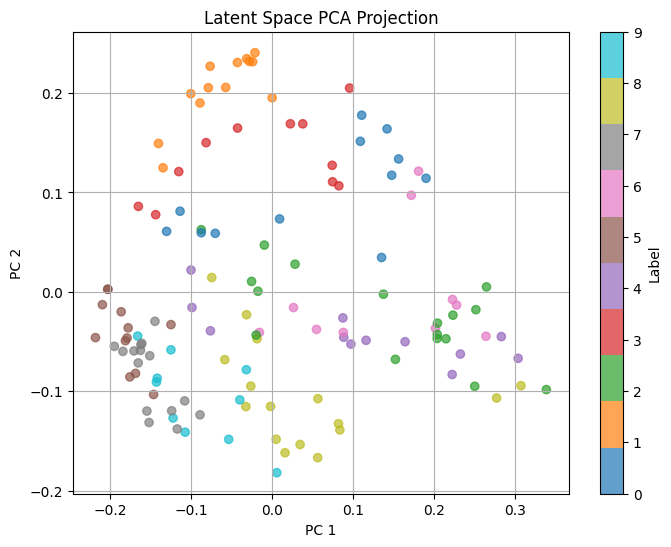

In [50]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Ambil batch dari test set
model.eval()
with torch.no_grad():
    imgs, labels = next(iter(test_loader))
    imgs = imgs.to(device)
    _, latents = model(imgs)

# Flatten: (batch_size, channels * H * W)
latents = latents.view(latents.size(0), -1).cpu().numpy()

# PCA ke 2 dimensi
pca = PCA(n_components=2)
pca_result = pca.fit_transform(latents)

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10), label='Label')
plt.title('Latent Space PCA Projection')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.grid(True)
plt.show()


## Eksperimen Tambahan: Variasi Ukuran Latent Space

Kami mencoba mengubah dimensi representasi laten menjadi 16, 64, dan 128 untuk melihat efeknya terhadap hasil rekonstruksi. Hasil menunjukkan bahwa ukuran latent terlalu kecil menyebabkan hilangnya detail visual, sementara ukuran lebih besar meningkatkan kualitas namun memperbesar kompleksitas.


In [51]:
# Cell 9: Simpan Model (opsional)
torch.save(model.state_dict(), 'conv_autoencoder_fashionmnist.pth')


## Refleksi dan Pembelajaran

Selama eksplorasi ini, saya belajar bahwa pemilihan arsitektur sangat berpengaruh terhadap kualitas rekonstruksi. Proses trial-and-error dalam mengatur jumlah layer dan dimensi laten memberikan pemahaman tentang bagaimana informasi dikompresi dan direkonstruksi. Saya juga menggunakan bantuan AI seperti ChatGPT untuk membantu debugging dan menyusun ide eksperimen tambahan, namun seluruh implementasi kode dan interpretasi dilakukan secara mandiri.
